## SIT796 Reinforcement Learning

Distinction Task 7.1 - Function Approximation Implementation  
**Angus Maiden** | ID 220595465

This task implements and compares the Semi-Gradient Sarsa(0) and Sarsa(λ) methods of control using linear function approximation.

In [1]:
# Import the necessary libraries.
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Invoke the model maze environment  from Task 1.2C.
env = gym.make('rl_gym_maze:rl-gym-maze-v0')
env.reset()

(0, 0)

In [2]:
# Define function for maximum key and value of a dictionary.
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

In [3]:
# Define epsilon-greedy policy to ensure exploration.
def random_action(a, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(4)

In [4]:
# Define 'Model' class for calculating the gradient and predicting the target.
# Note, in linear function approximation the gradient weights,
# W are equal to the feature vector X(s).
class Model:
    def __init__(self):
        self.theta = np.random.randn(25) / np.sqrt(25)
    
    def sa2x(self, s, a):
        return np.array([
        s[0]/10                 if a == 0 else 0,
        s[1]/10                 if a == 0 else 0,
        s[0]*s[1]/100           if a == 0 else 0,
        s[0]*s[0]/100           if a == 0 else 0,
        s[1]*s[1]/100           if a == 0 else 0,
        1                       if a == 0 else 0,
        s[0]/10                 if a == 1 else 0,
        s[1]/10                 if a == 1 else 0,
        s[0]*s[1]/100           if a == 1 else 0,
        s[0]*s[0]/100           if a == 1 else 0,
        s[1]*s[1]/100           if a == 1 else 0,
        1                       if a == 1 else 0,
        s[0]/10                 if a == 2 else 0,
        s[1]/10                 if a == 2 else 0,
        s[0]*s[1]/100           if a == 2 else 0,
        s[0]*s[0]/100           if a == 2 else 0,
        s[1]*s[1]/100           if a == 2 else 0,
        1                       if a == 2 else 0,
        s[0]/10                 if a == 3 else 0,
        s[1]/10                 if a == 3 else 0,
        s[0]*s[1]/100           if a == 3 else 0,
        s[0]*s[0]/100           if a == 3 else 0,
        s[1]*s[1]/100           if a == 3 else 0,
        1                       if a == 3 else 0,
        1
        ])

    def predict(self, s, a):
        x = self.sa2x(s, a)
        return self.theta.dot(x)

    def grad(self, s, a):
        return self.sa2x(s, a)

In [5]:
# Define function for calculating Q(S,A,w) from gradient.
def getQs(model, s):
    # we need Q(s,a) to choose an action
    # i.e. a = argmax[a]{ Q(s,a) }
    Qs = {}
    for a in range(4):
        q_sa = model.predict(s, a)
        Qs[a] = q_sa
    return Qs

In [6]:
# Run an episode with optimised policy.
def getPolicy(model):
    
    # Initalise policy (P), value (V) and action-value (Q) dictionaries.
    P = {}
    V = {}
    Q = {}

    # Sweep through each state.
    for x in range(10):
        for y in range(10):
        
            state = (x,y)
            
            Qs = getQs(model, state)
            Q[state] = Qs
            
            action, max_q = max_dict(Qs)
            
            P[state] = action
            V[state] = max_q

            # Update environment state to next in sweep.
            env.location = (x,y+1)
            if env.location[1] == 10:
                env.location = (x+1, 0)

    return P, V, Q

In [7]:
# Define function to run an episode from a policy.
def runMaze(P):
    
    # Initalise environment and other variables.
    state = env.reset()
    done = False
    counter = 0
    total_reward = 0
    
    # Limit episode to 1000 steps (hoping to finish the task before limit).
    for step in range(1000):
    
        # Select next action based on optimal policy.
        action = P[state]
    
        # Get state, reward and done variables from environment 'step' function.
        next_state, reward, done, info = env.step(action)
        
        # Display current location as agent moves through maze.
        print(f'\rStep: {counter} | Location: {next_state} | Reward: {reward}', end='')
        
        # Update counter and reward tracking variables.
        counter += 1
        total_reward += reward
  
        # If we reach the goal, end the episode.
        if done:
            break
        
        # S = S'
        state = next_state
    
    # Create a variable for calculating and displaying 'Finished maze' statistics.
    if done:
        finished = 'Yes'
    else:
        finished = 'No'
    
    # Display run results.
    print(f'\rNumber of steps: {counter} | Finished Maze?: {finished} | Total Reward: {total_reward}\n')

## Sarsa(0)

In [8]:
# Initialize model and other variables.
model = Model()
deltas = []
gamma = 0.9
ALPHA = 0.1
t = 1.0
total_rewards_list = []
counter_list = []

# Repeat for 5000 iterations.
for it in range(5000):
    
    # Decrement alpha and epsilon every 100 iterations.
    if it % 100 == 0:
        t += .01
    alpha = ALPHA / t
    
    # S = 0
    state = env.reset()
    done = False

    # Get Q(S, A, w) so we can choose the first action.
    Qs = getQs(model, state)
    
    # Initial epsilon-greedy action.
    action = max_dict(Qs)[0]
    action = random_action(action, eps=0.5 / t)
    
    # Initialise tracking variables.
    biggest_change = 0
    counter = 0
    total_reward = 0
    
    # Loop for every step of the episode.
    while not done and counter <= 1000:
        
        # Take action, get S' and R'.
        next_state, reward, done, info = env.step(action)
        
        # Increment tracking variables.
        counter += 1
        total_reward += reward

        # Display current location as agent moves through maze.
        print(f'\rIteration: {it+1} | Step: {counter} | Location: {next_state}          ', end='')
        
        # Store current weights.
        old_theta = model.theta.copy()
        
        # Update equations.
        if next_state[0] == 9 and next_state[1] == 9:
            
            # Terminal state, doesn't include Q(S', A', w).
            model.theta += alpha * (reward - model.predict(state, action)) * model.grad(state, action)
        
        else:
            
            # Not terminal.
            # Get Q(S, A, w).
            Qs2 = getQs(model, next_state)
            
            # Take epsilon-greedy action.
            next_action, maxQs2a2 = max_dict(Qs2)
            next_action = random_action(next_action, eps = 0.5 / t)
            
            # Update Q(S, A, w) as we experience the episode.
            model.theta += alpha * (reward + gamma * maxQs2a2 - model.predict(state, action)) \
            * model.grad(state, action)
      
            # Next state becomes current state.
            state = next_state
            action = next_action
    
    # Update tracking lists for plotting.
    total_rewards_list.append(total_reward)
    counter_list.append(counter)
    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)

Iteration: 5000 | Step: 25 | Location: (9, 9)            

In [9]:
# Get final policy, state values and state-action values.
P, V, Q = getPolicy(model)
# Run an episode with final policy.
runMaze(P)

Number of steps: 18 | Finished Maze?: Yes | Total Reward: -7



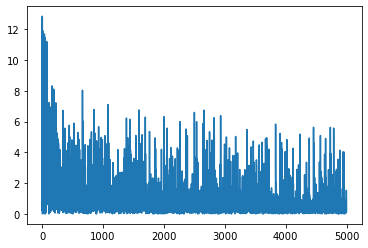

[-17.6916751   -2.79836987  19.66204924  12.84912779  10.05081586
  -2.17951694 -37.88481079 -12.57409042  48.95273933  12.91891252
  22.89070779  -2.04752764 -25.65882834  -3.11964622  22.13627399
  24.16533605   9.71875358  -2.39970333 -25.05907616   0.79088052
  19.33195524  25.18826551   6.6491099   -1.89299928  -8.06840652]


In [10]:
# Plot change in gradient over time.
plt.plot(deltas)
plt.show()
print(model.theta)

In [11]:
# Display final state values.
print(f'Grid view of the state values:\n')
np.set_printoptions(precision = 2, suppress = True, linewidth = 100)
print(np.array([v for v in V.values()]).reshape([10,10]))

Grid view of the state values:

[[ -9.96  -9.82  -9.54  -9.13  -8.58  -7.9   -7.09  -6.15  -5.07  -2.89]
 [-11.89 -11.87 -11.4  -10.8  -10.06  -9.19  -8.19  -7.05  -5.27  -2.14]
 [-13.27 -13.06 -12.64 -11.97 -11.04  -9.97  -8.78  -7.45  -4.75  -1.14]
 [-14.4  -13.99 -13.38 -12.56 -11.51 -10.25  -8.86  -7.3   -3.98   0.12]
 [-15.27 -14.66 -13.85 -12.8  -11.48 -10.03  -8.45  -6.73  -2.95   1.64]
 [-15.88 -15.08 -13.84 -12.46 -10.95  -9.3   -7.53  -5.62  -1.66   3.42]
 [-15.93 -14.62 -13.19 -11.61  -9.91  -8.07  -6.1   -4.    -0.11   5.46]
 [-15.16 -13.66 -12.03 -10.27  -8.37  -6.34  -4.17  -1.88   1.7    7.76]
 [-13.89 -12.2  -10.37  -8.41  -6.32  -4.1   -1.74   0.75   3.76  10.32]
 [-12.11 -10.23  -8.21  -6.06  -3.77  -1.35   1.2    3.88   6.7   13.13]]


<function matplotlib.pyplot.show(close=None, block=None)>

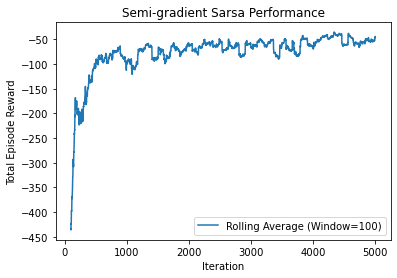

In [12]:
# Plot the results as a moving average (to see trends).
rolling_average_rewards = pd.DataFrame(total_rewards_list).rolling(100).mean()
plt.plot(rolling_average_rewards)
plt.title('Semi-gradient Sarsa Performance')
plt.xlabel('Iteration')
plt.ylabel('Total Episode Reward')
plt.legend(['Rolling Average (Window=100)'])
plt.show

### Sarsa(λ)

In [13]:
# Initialize model and other variables.
model_sarsalambda = Model()
deltas_sarsalambda = []
gamma = 0.9
lambda_value = 0.5
ALPHA = 0.1
t = 1.0
total_rewards_list_sarsalambda = []
counter_list_sarsalambda = []

# Repeat for 5000 iterations.
for it in range(5000):
    
    # Decrement alpha and epsilon every 100 iterations.
    if it % 100 == 0:
        t += .01
    alpha = ALPHA / t
    
    # S = 0
    state = env.reset()
    done = False

    # Get Q(S, A, w) so we can choose the first action.
    Qs = getQs(model_sarsalambda, state)
    
    # Initial epsilon-greedy action.
    action = max_dict(Qs)[0]
    action = random_action(action, eps=0.5 / t)

    # Initalise tracking variables.
    biggest_change = 0
    counter = 0
    total_reward = 0
    z = np.zeros(25)
    
    # Loop for every step of the episode.
    while not done and counter <= 1000:
        
        # Take action, get S' and R'.
        next_state, reward, done, info = env.step(action)
        
        # Increment tracking variables.
        counter += 1
        total_reward += reward

        # Display current location as agent moves through maze.
        print(f'\rIteration: {it+1} | Step: {counter} | Location: {next_state}          ', end='')
        
        # Store current weights.
        old_theta = model_sarsalambda.theta.copy()
        z = gamma * lambda_value * z + model_sarsalambda.grad(state, action)
        
        # Update equations.
        if next_state[0] == 9 and next_state[1] == 9:
            
            # Terminal state, doesn't include Q(S', A', w).
            model_sarsalambda.theta += alpha * (reward - model_sarsalambda.predict(state, action)) \
            * model_sarsalambda.grad(state, action) * z
        
        else:
            
            # Not terminal.
            # Get Q(S, A, w).
            Qs2 = getQs(model_sarsalambda, next_state)
            next_action, maxQs2a2 = max_dict(Qs2)
            next_action = random_action(next_action, eps = 0.5 / t)
            
            # Update Q(S, A, w) as we experience the episode.
            model_sarsalambda.theta += alpha * (reward + gamma * maxQs2a2 - model_sarsalambda.predict(state, action)) \
            * model_sarsalambda.grad(state, action) * z
      
            # Next state becomes current state.
            state = next_state
            action = next_action
    
    # Update tracking lists for plotting.
    total_rewards_list_sarsalambda.append(total_reward)
    counter_list_sarsalambda.append(counter)
    biggest_change = max(biggest_change, np.abs(model_sarsalambda.theta - old_theta).sum())
    deltas_sarsalambda.append(biggest_change)

Iteration: 5000 | Step: 30 | Location: (9, 9)            

In [14]:
# Get final policy, state values and state-action values.
P_sarsalambda, V_sarsalambda, Q_sarsalambda = getPolicy(model_sarsalambda)
# Run an episode with final policy.
runMaze(P_sarsalambda)

Number of steps: 18 | Finished Maze?: Yes | Total Reward: -7



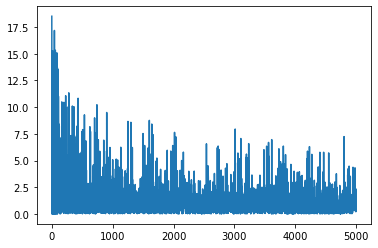

[ -10.9   -11.     19.22    7.07   18.5  -446.14  -26.59  -22.09   41.24    6.69   33.42 -446.48
  -16.22   -8.74   23.55   11.43   14.55 -446.51  -10.77   -4.62   15.38   12.82   10.95 -445.25
  436.97]


In [15]:
# Plot change in gradient over time.
plt.plot(deltas_sarsalambda)
plt.show()
print(model_sarsalambda.theta)

In [16]:
# Display final state values.
print(f'Grid view of the state values:\n')
np.set_printoptions(precision = 2, suppress = True, linewidth = 100)
print(np.array([v for v in V_sarsalambda.values()]).reshape([10,10]))

Grid view of the state values:

[[ -8.29  -8.64  -8.77  -8.69  -8.38  -7.86  -7.12  -6.16  -4.98  -2.32]
 [ -9.24  -9.43  -9.41  -9.18  -8.72  -8.04  -7.15  -6.03  -4.7   -1.2 ]
 [ -9.93  -9.97  -9.8   -9.41  -8.8   -7.96  -6.92  -5.65  -4.16   0.05]
 [-10.36 -10.26  -9.93  -9.38  -8.62  -7.63  -6.43  -5.01  -3.27   1.44]
 [-10.54 -10.28  -9.8   -9.1   -8.18  -7.04  -5.68  -4.11  -2.16   2.96]
 [-10.47 -10.05  -9.41  -8.56  -7.49  -6.2   -4.68  -2.95  -0.92   4.62]
 [-10.13  -9.56  -8.77  -7.77  -6.54  -5.09  -3.43  -1.54   0.56   6.41]
 [ -9.54  -8.82  -7.88  -6.71  -5.33  -3.73  -1.92   0.12   2.38   8.33]
 [ -8.7   -7.82  -6.72  -5.41  -3.87  -2.12  -0.15   2.05   4.46  10.39]
 [ -7.59  -6.56  -5.31  -3.84  -2.15  -0.25   1.88   4.23   6.79  12.58]]


<function matplotlib.pyplot.show(close=None, block=None)>

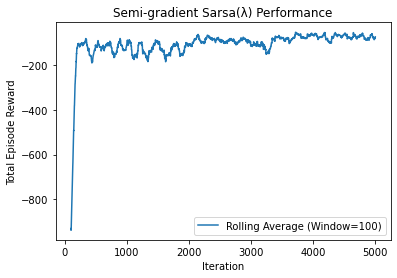

In [17]:
# Plot the results as a moving average (to see trends).
rolling_average_rewards_sarsalambda = pd.DataFrame(total_rewards_list_sarsalambda).rolling(100).mean()
plt.plot(rolling_average_rewards_sarsalambda)
plt.title('Semi-gradient Sarsa(λ) Performance')
plt.xlabel('Iteration')
plt.ylabel('Total Episode Reward')
plt.legend(['Rolling Average (Window=100)'])
plt.show